최종수정일시. 21-05-19 (이해강)

In [448]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timezone, timedelta
from math import ceil

# 경고창 무시
import warnings
warnings.filterwarnings(action='ignore')

# matplotlib 한글 폰트 오류 해결
import platform
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='appleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system.... sorry.....')

### 데이터 불러오고 결측치 처리

In [483]:
ndf = pd.read_excel('과제수정DB.xlsx',encoding='utf-8')
ndf['app_yn'].replace(np.nan, 'N', inplace=True)
ndf.dropna(axis=0, inplace=True)

### 주차 구하는 컬럼 생성

In [484]:
# 가입날짜 - 그 해, 그 달 n주차 가입 
ndf['reg_date_ym']=ndf['reg_date'].dt.strftime('%y-%m')
ndf['reg_date_w']=1

#당월 n주차 구하는 함수 
def week_of_month(dt):

    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    return int(ceil(adjusted_dom/7.0))

#당월 n주차 구하기
for idx, (y, m, n) in enumerate(zip(ndf['reg_date'].dt.year, ndf['reg_date'].dt.month, ndf['reg_date'].dt.day)) :
    temp_week=week_of_month(datetime(y,m,n))
    ndf['reg_date_w'].iloc[idx]= temp_week

ndf['reg_date_ymw']=ndf['reg_date_ym']+'-'+ndf['reg_date_w'].astype(str)


In [485]:
# 주문날짜 - 그 해, 그 달 n주차 구매
ndf['order_date_ym']=ndf['order_date'].dt.strftime('%y-%m')
ndf['order_date_w']=1

for idx, (y, m, n) in enumerate(zip(ndf['order_date'].dt.year, ndf['order_date'].dt.month, ndf['order_date'].dt.day)) :
    temp_week=week_of_month(datetime(y,m,n))
    ndf['order_date_w'].iloc[idx]= temp_week

ndf['order_date_ymw']=ndf['order_date_ym']+'-'+ndf['order_date_w'].astype(str)

# 사용자 retention 분석
- 월간 사용자 Cohort를 바탕으로 월별 재구매율(retention) 분석하기
- heatmap으로 한눈에 재구매율을 파악 가능
- 유저들을 두 가지 경우로 나눠서 Cohort 분석 실시
 1. 기존유저들 (가입일 21년 이전)
 2. 신규유저들 (가입일 21년 1,2,3월)

In [487]:
# 새로운 컬럼 생성
ndf['reg_Month'] = ndf['reg_date'].apply(lambda x : datetime(x.year, x.month, 1)) # 가입월
ndf['order_Month'] = ndf['order_date'].apply(lambda x : datetime(x.year, x.month, 1)) # 주문월

### 날짜 기준으로 데이터 나누기
- origin : 21년 이전 가입자들
- new : 21년 1,2,3월 가입자들

In [488]:
origin = ndf[ndf['reg_date']<'2021-01-01']
new = ndf[ndf['reg_date']>='2021-01-01']

## 1-1. 기존유저들의 월별 코호트 분석

In [489]:
cohort_group = origin.groupby(['reg_Month', 'order_Month'])
cohort_df = cohort_group['USER'].apply(lambda x : len(np.unique(x))).reset_index()
cohort_df = cohort_df.pivot(index='reg_Month', columns = 'order_Month')
customer_cohort = cohort_df.div(cohort_df.iloc[:, 0], axis=0) * 100 # 백분율로 표현
customer_cohort = customer_cohort.round(decimals=2)

Text(115.0, 0.5, '가입 일(년-월)')

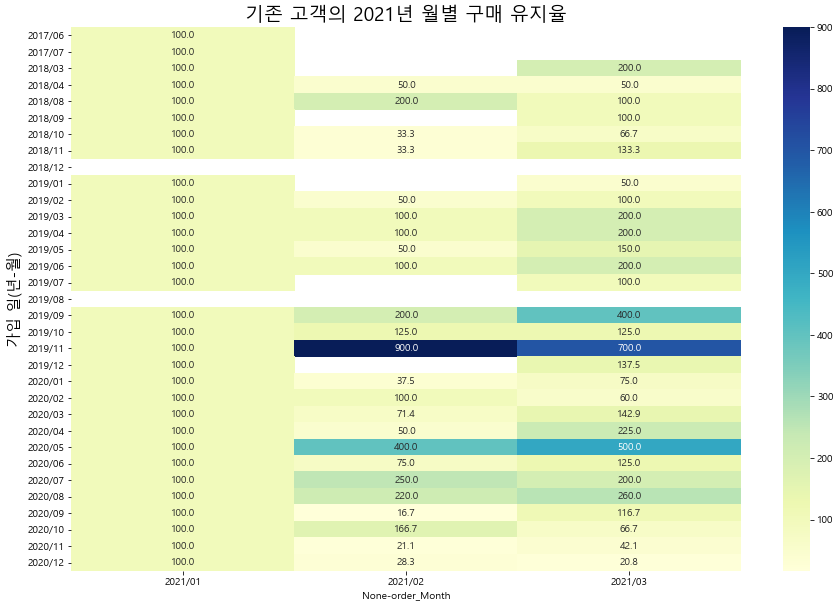

In [490]:
xticks = ['2021/01', '2021/02', '2021/03']
yticks = ['2017/06','2017/07','2018/03','2018/04','2018/08','2018/09','2018/10','2018/11','2018/12',
          '2019/01','2019/02','2019/03','2019/04','2019/05','2019/06','2019/07','2019/08','2019/09','2019/10','2019/11','2019/12',
          '2020/01','2020/02','2020/03','2020/04','2020/05','2020/06','2020/07','2020/08','2020/09','2020/10','2020/11','2020/12']
         

plt.figure(figsize = (15,10))
plt.title('기존 고객의 2021년 월별 구매 유지율', fontsize=19)
sns.heatmap(customer_cohort,
           annot = True,
           xticklabels = xticks,
           yticklabels = yticks,            
           fmt = '.1f',
           cmap = 'YlGnBu')
plt.ylabel('가입 일(년-월)', fontsize=15)

#### Insight
- 19, 20년도 가입자들의 구매 리텐션은 꽤 유지되고 있음.
- 하지만, 17, 18년도 가입자들의 구매 리텐션은 상당히 낮은 것을 확인할 수 있음.

## 1-2. 기존유저들의 주차별 코호트 분석

In [491]:
def get_unique_no(x):
    return len(np.unique(x))
cohort_group = ndf.groupby(['reg_date_ym', 'order_date_ymw'])
cohort_df = cohort_group['USER'].apply(get_unique_no).reset_index()
cohort_old = cohort_df[cohort_df.reg_date_ym<'21-01']
cohort_old_pivot = cohort_old.pivot(index='reg_date_ym', columns = 'order_date_ymw')
div_num=cohort_old.groupby('reg_date_ym')['USER'].sum()
cohort_old_pivot = cohort_old_pivot.div(div_num, axis=0) * 100

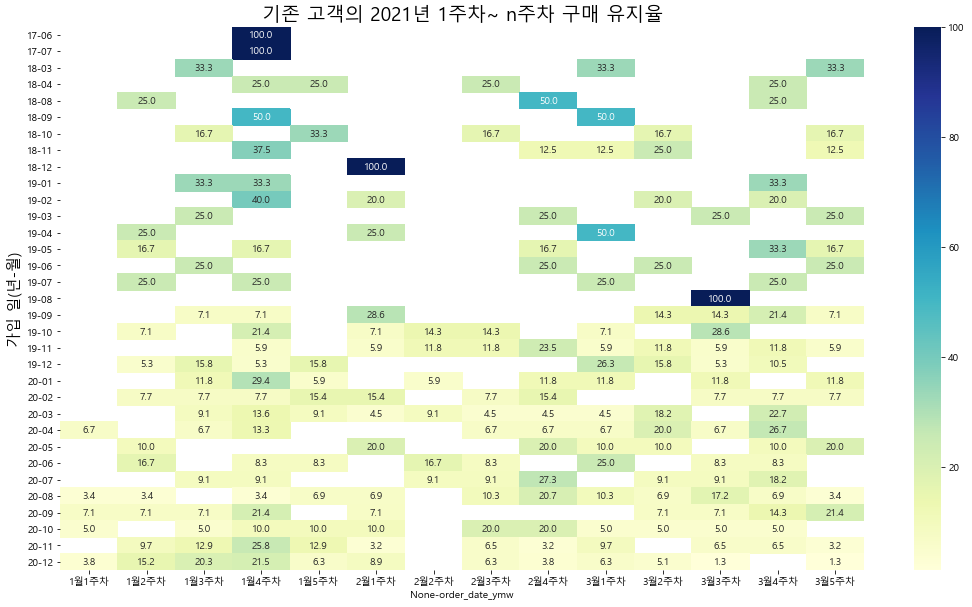

In [492]:
xticks = [(str(k[1][4])+'월'+ str(k[1][6]) + '주차') for k in cohort_old_pivot.columns]

plt.figure(figsize=(18, 10))
plt.title('기존 고객의 2021년 1주차~ n주차 구매 유지율', fontsize=19)
sns.heatmap(cohort_old_pivot, annot=True, fmt = '.1f', xticklabels = xticks, cmap='YlGnBu')
plt.ylabel('가입 일(년-월)', fontsize=15)
plt.show()

#### Insight
- 마찬가지로 비교적 최근(19,20년도)에 가입한 유저들의 리텐션이 유지되고 있음.

## 2-1. 신규유저들의 월별 코호트 분석

In [523]:
cohort_group2 = new.groupby(['reg_Month', 'order_Month'])
cohort_df2 = cohort_group2['USER'].apply(lambda x : len(np.unique(x))).reset_index()
cohort_df2 = cohort_df2.pivot(index='reg_Month', columns = 'order_Month')
for i in range(3):
    first = cohort_df2.iloc[i][i]
    for j in range(3):
        cohort_df2.iloc[i][j] = cohort_df2.iloc[i][j]/first *100

Text(61.0, 0.5, '가입 일(년-월)')

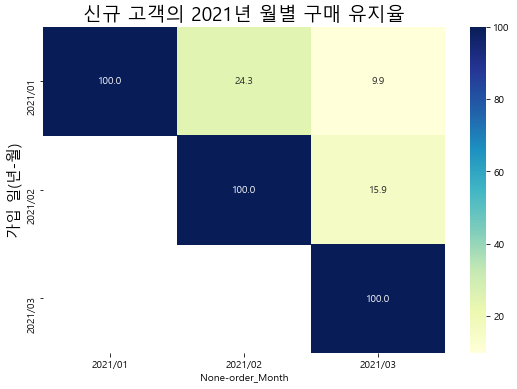

In [524]:
xticks = ['2021/01', '2021/02', '2021/03']
yticks = ['2021/01', '2021/02', '2021/03']

plt.figure(figsize = (9,6))
plt.title('신규 고객의 2021년 월별 구매 유지율', fontsize=19)
sns.heatmap(cohort_df2,
           annot = True,
           xticklabels = xticks,
           yticklabels = yticks,            
           fmt = '.1f',
           cmap = 'YlGnBu')
plt.ylabel('가입 일(년-월)', fontsize=15)

#### Insight
- 신규유저(21년도 가입)들의 리텐션은 가입한 월에 비해 지속적으로 낮아지고 있음.

## 2-2. 신규유저들의 주차별 코호트 분석

In [497]:
cohort_group = ndf.groupby(['reg_date_ymw', 'order_date_ymw'])
cohort_df = cohort_group['USER'].apply(get_unique_no).reset_index()
cohort_new = cohort_df[cohort_df.reg_date_ymw>='21-01-1'] #신규 고객만
cohort_new_pivot = cohort_new.pivot(index='reg_date_ymw', columns = 'order_date_ymw')
for i in range(len(cohort_new_pivot)):
    first = cohort_new_pivot.iloc[i][i]
    for j in range(len(cohort_new_pivot)):
        cohort_new_pivot.iloc[i][j] = cohort_new_pivot.iloc[i][j]/first *100

Text(159.40625, 0.5, '21년 월별 n주차 가입')

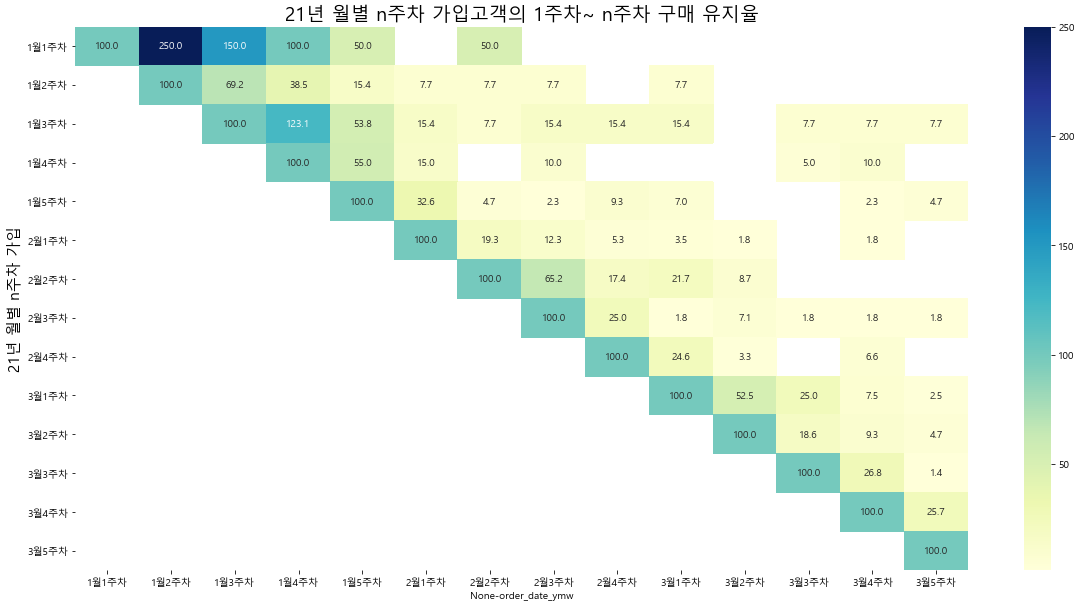

In [509]:
xticks = [(str(k[1][4])+'월'+ str(k[1][6]) + '주차') for k in cohort_new_pivot.columns]
yticks = [(str(k[4])+'월'+ str(k[6]) + '주차') for k in cohort_new_pivot.index]

plt.figure(figsize = (20,10))
plt.title('21년 월별 n주차 가입고객의 1주차~ n주차 구매 유지율', fontsize=19)
sns.heatmap(cohort_new_pivot,
           annot = True,
           xticklabels = xticks,
           yticklabels = yticks, 
           fmt = '.1f',
           cmap = 'YlGnBu')
plt.ylabel('21년 월별 n주차 가입', fontsize=15)

#### Insight
- 몇몇 주차를 제외하고 가입시점 기준, 일주일 뒤부터 리텐션이 확 줄어드는 것을 확인할 수 있음.
- 2주 이상으로 유저들의 리텐션을 끌어올릴 수 있는 방안이 필요해 보임.

## 2-3. 신규유저들의 1월의 일별 코호트 분석

In [475]:
new_day = new[:]
cohort_group = new_day.groupby(['reg_date', 'order_date'])
cohort_1M = cohort_group['USER'].apply(lambda x : len(np.unique(x))).reset_index()
cohort_1M = cohort_1M[cohort_1M['order_date']<'2021-02']
cohort_1M = cohort_1M.pivot(index='reg_date', columns = 'order_date')

Text(160.0, 0.5, '가입 일(월-일)')

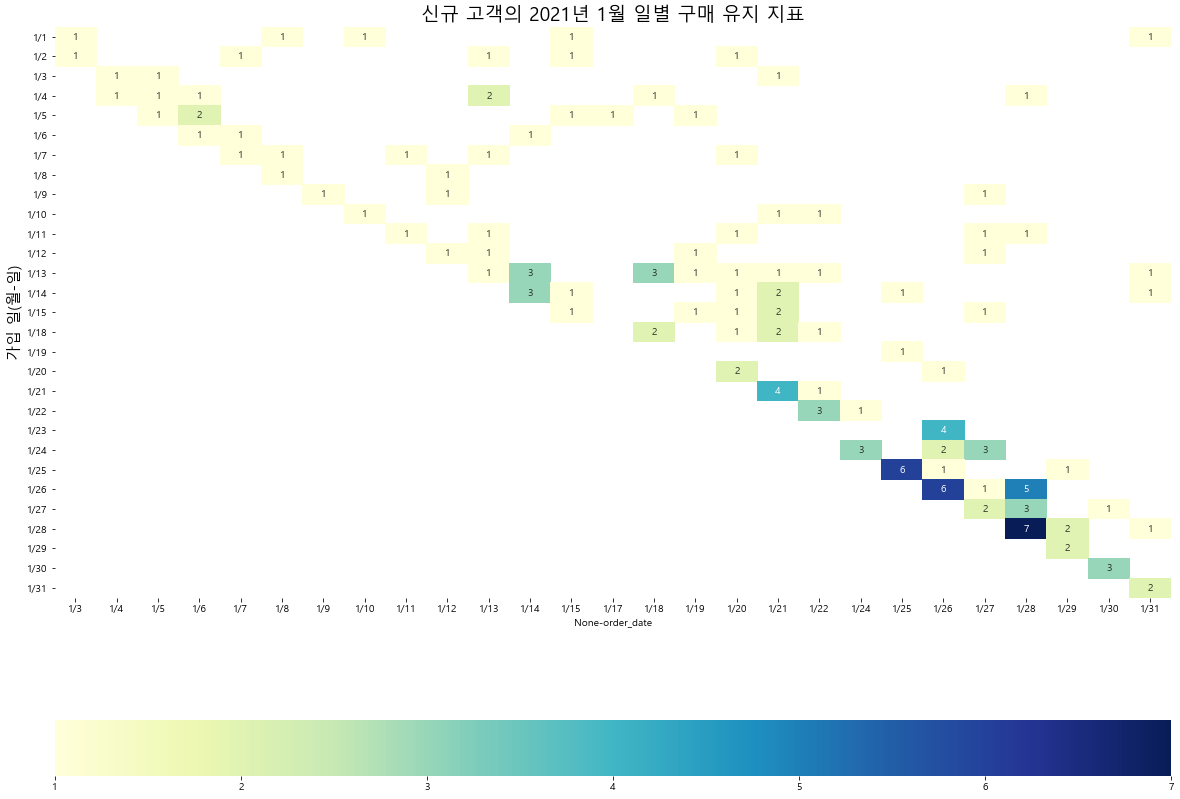

In [522]:
xticks = [(str(k[1].month)+'/'+ str(k[1].day)) for k in cohort_1M.columns]
yticks = [(str(k.month)+'/'+ str(k.day)) for k in cohort_1M.index]

plt.figure(figsize = (20,15))
plt.title('신규 고객의 2021년 1월 일별 구매 유지 지표', fontsize=19)
sns.heatmap(cohort_1M,
           annot = True,
           xticklabels = xticks,
           yticklabels = yticks,
           cbar_kws={"orientation": "horizontal"},
           fmt = '.0f',
           cmap = 'YlGnBu')
plt.ylabel('가입 일(월-일)', fontsize=15)

#### Insight
- 1월에 가입, 구매한 유저 152명
- 가입한지 하루안에 구매자로 전환된 유저들이 다량 관측. (39개 그룹)
- 하지만 전환 이후 신규유저들의 리텐션을 유지할 필요가 있음.

## 2-4. 신규유저들의 2월의 일별 코호트 분석

In [471]:
new_day = new[:]
cohort_group = new_day.groupby(['reg_date', 'order_date'])
cohort_2M = cohort_group['USER'].apply(lambda x : len(np.unique(x))).reset_index()
cohort_2M = cohort_2M[cohort_2M['reg_date']<'2021-03']
cohort_2M = cohort_2M[cohort_2M['reg_date']>'2021-01-31']
cohort_2M = cohort_2M[cohort_2M['order_date']<'2021-03']
cohort_2M = cohort_2M.pivot(index='reg_date', columns = 'order_date')

Text(160.0, 0.5, '가입 일(월-일)')

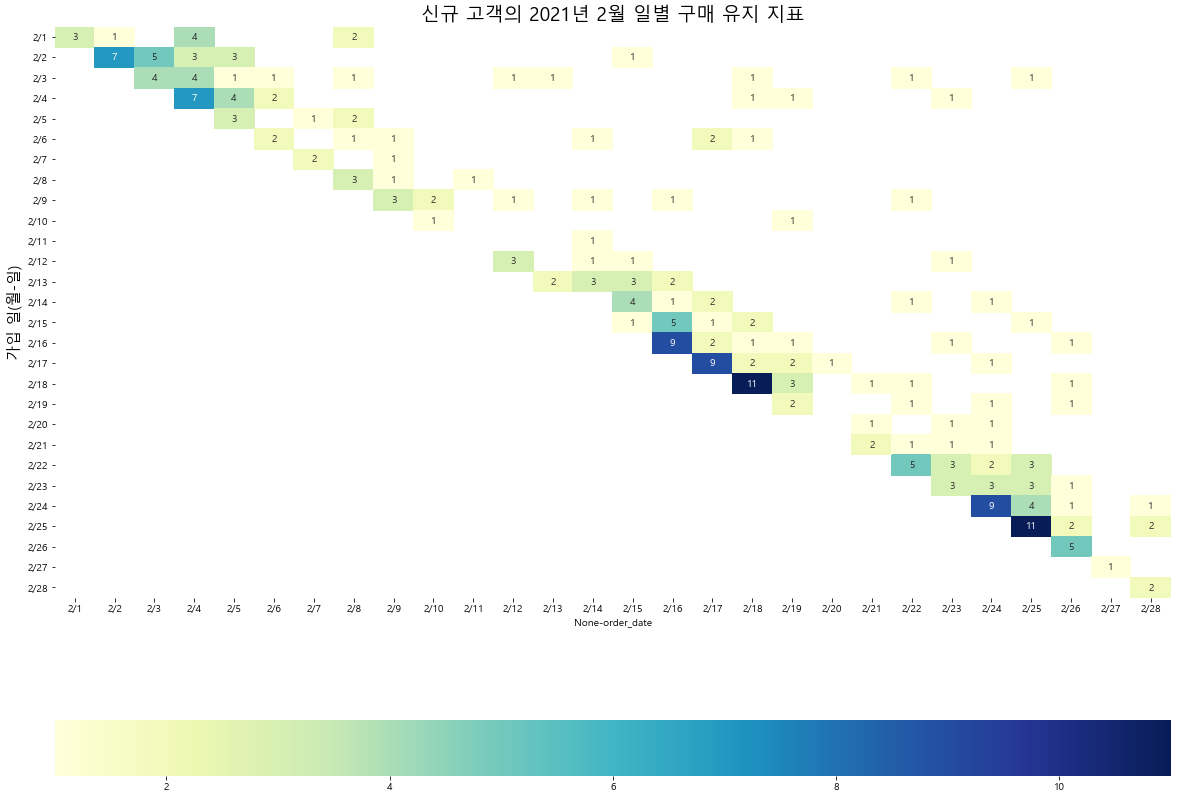

In [521]:
xticks = [(str(k[1].month)+'/'+ str(k[1].day)) for k in cohort_2M.columns]
yticks = [(str(k.month)+'/'+ str(k.day)) for k in cohort_2M.index]

plt.figure(figsize = (20,15))
plt.title('신규 고객의 2021년 2월 일별 구매 유지 지표', fontsize=19)
sns.heatmap(cohort_2M,
           annot = True,
           xticklabels = xticks,
           yticklabels = yticks,
           cbar_kws={"orientation": "horizontal"},
           fmt = '.0f',
           cmap = 'YlGnBu')
plt.ylabel('가입 일(월-일)', fontsize=15)

#### Insight
- 2월에 가입, 구매한 유저는 251명. (1월에 비해 65% 증가) 
- 1월과 마찬가지로 가입한지 하루안에 구매자로 전환된 유저들이 다량 관측. (43개 그룹으로 1월에 비해 10% 증가)
- 1월에 비해 유저들의 리텐션이 유지되고 있음.

## 2-5. 신규유저들의 3월의 일별 코호트 분석

In [473]:
new_day = new[:]
cohort_group = new_day.groupby(['reg_date', 'order_date'])
cohort_3M = cohort_group['USER'].apply(lambda x : len(np.unique(x))).reset_index()
cohort_3M = cohort_3M[cohort_3M['reg_date']>'2021-02-28']
cohort_3M = cohort_3M[cohort_3M['order_date']>'2021-02-28']
cohort_3M = cohort_3M.pivot(index='reg_date', columns = 'order_date')

Text(160.0, 0.5, '가입 일(월-일)')

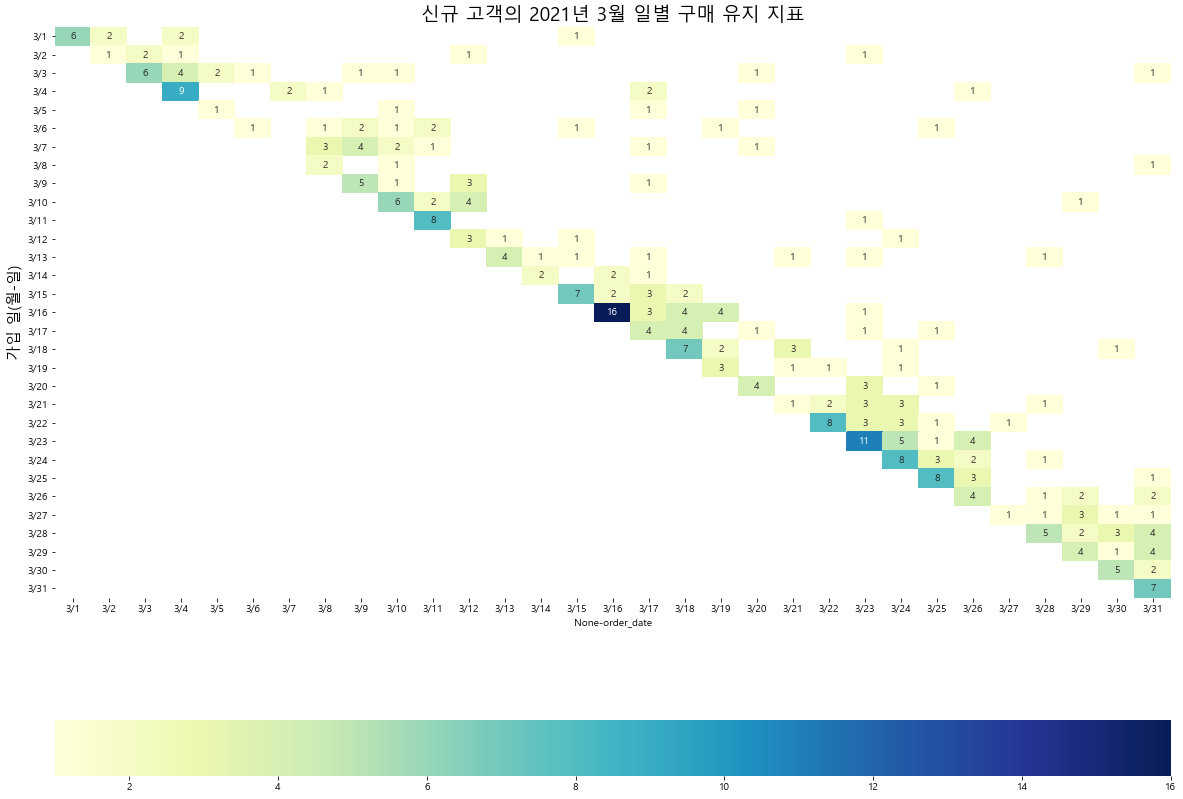

In [520]:
xticks = [(str(k[1].month)+'/'+ str(k[1].day)) for k in cohort_3M.columns]
yticks = [(str(k.month)+'/'+ str(k.day)) for k in cohort_3M.index]

plt.figure(figsize = (20,15))
plt.title('신규 고객의 2021년 3월 일별 구매 유지 지표', fontsize=19)
sns.heatmap(cohort_3M,
           annot = True,
           xticklabels = xticks,
           yticklabels = yticks,
           cbar_kws={"orientation": "horizontal"},
           fmt = '.0f',
           cmap = 'YlGnBu')
plt.ylabel('가입 일(월-일)', fontsize=15)

#### Insight
- 3월에 가입, 구매한 유저는 339명.(2월에 비해 35% 증가)     
- 다달이 가입, 구매 유저가 증가하고 있음.
- 1, 2월과 마찬가지로 가입한지 하루안에 구매자로 전환된 유저들이 다량 관측.(51개 그룹으로 2월에 비해 18%증가)
- 유저들의 리텐션이 점차 유지되고 있으나 일주일정도가 고비로 보임.
- 따라서, 유저들의 리텐션을 일주일 이상 유지하기 위한 전략이 필요.

# Action Plan 도출

### 1) 일주일이 지나면 유저들의 구매횟수가 현저히 저하된다. 
    - 2주차까지 구매유지를 늘리는게 핵심!
    - 꾸준히 구매유지를 시키는게 관건!
    - 한달 멤버쉽 무료, 적립금 이벤트와 같은 성공사례를 벤치마킹하여 이벤트 실행 

### 2) 17,18년도에 가입한 기존유저들의 리텐션도 끌어올릴 필요가 있다.
    - 고인물 유저들을 리마인드 시킬 수 있는 컴백 이벤트 실행(쿠폰지급)
    - 푸쉬노티피케이션을 활성화시킬 수 있는 이벤트 실행

### 3) 3월로 갈수록 유저들의 이용이 늘어나고 있다.
    - 서비스가 점점 성장하면서 신규 유저들이 계속 유입되고 있음
    - 날씨가 점차 따뜻해지면서 유저들이 더 많이 유입될 수 있음
    - 계절성을 참고하여 봄맞이 이벤트 실행
    - 중고거래, 명품의 수요가 많은 MZ세대의 세대적 특징을 이용한 마케팅 전략도 필요해 보임(라플 이벤트 등)